In [19]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import norm

import GCExitPathwayModel as GCEPM
importlib.reload(GCEPM)

<module 'GCExitPathwayModel' from 'd:\\UvA\\bioinformatics\\cell-differentiation-in-affinity-maturation-of-the-germinal-center\\GCExitPathwayModel.py'>

In [20]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [21]:
mu = np.array([mu_p, mu_b, mu_r])
sigma = np.array([sigma_p, sigma_b, sigma_r])
k = np.array([k_p, k_b, k_r])
lam = np.array([lam_p, lam_b, lam_r])

In [22]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4

y0 = np.array([p0, b0, r0])

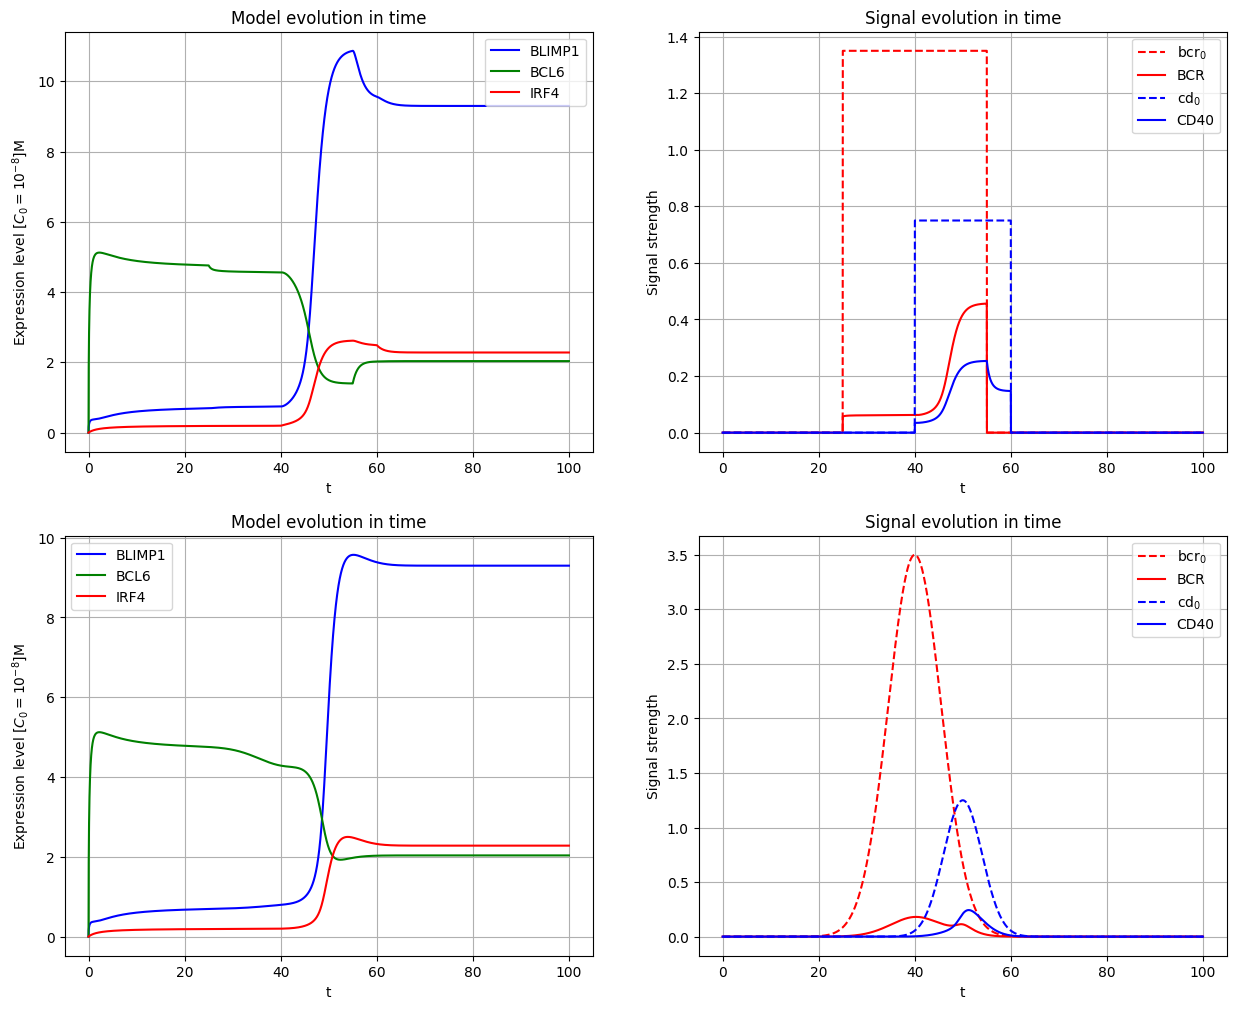

In [24]:
# Solutions and plotting
fig, ax = plt.subplots(2,2,figsize=(15,12))

# Heaviside signal
bcrt = lambda t : GCEPM.rectangle_signal(t, strength=1.35, tstart=25, tend=55)
cdt = lambda t : GCEPM.rectangle_signal(t, strength=0.75, tstart=40, tend=60)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)

GCEPM.plot_model(ax[0,0], t, sol)
GCEPM.plot_singals(ax[0,1], t, sol, k_b, bcrt, cdt)

# Bell curve signal
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=3.5, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=1.25, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)

GCEPM.plot_model(ax[1,0], t, sol)
GCEPM.plot_singals(ax[1,1], t, sol, k_b, bcrt, cdt)